In [1]:
import warnings
warnings.filterwarnings('ignore')
    # Supresses Neural Net Warning "ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached
        # and the optimization hasn't converged yet."
    # Supresses QDA Warning "UserWarning: Variables are collinear"

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [3]:
#Will ONLY work if the model has a predict function
def getPredictions(model, passengerIDsColumn: pd.Series, dataArrayToPredict: np.array) -> pd.DataFrame:
    results = model.predict(dataArrayToPredict)
    return pd.concat([passengerIDsColumn, pd.DataFrame({'Survived' : results})], axis=1)

In [4]:
# For Numeric and Ordinal values, NOTHING is done, for Categorical values, they are converted to Ordinal values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
def preprocessData(dataToEncode: pd.DataFrame, remainingData: pd.DataFrame, columnsToProcess: list) -> np.array:
    colsToEncode = []
    remainingCols = []
        
    for col in columnsToProcess:
        if col[1] == 'C':
            colsToEncode.append(col[0])
        else:
            remainingCols.append(col[0])
    
    resultArr = dataToEncode[remainingCols].values
    
    combinedData = dataToEncode[colsToEncode].append(remainingData[colsToEncode], ignore_index=True)
    
    for column in colsToEncode:
        uniqueCategories = combinedData[column].unique().tolist()
        uniqueCategories.sort()
        enc = preprocessing.OneHotEncoder(categories=[uniqueCategories])
        tempDataArray = enc.fit_transform(dataToEncode[[column]].values).toarray()
        resultArr = np.append(resultArr, tempDataArray, axis=1)
    
    return resultArr

In [5]:
class EnsembleEstimator:
    def __init__(self):
        self.classifiers = [
            ("10 Nearest Neighbors (Brute)", KNeighborsClassifier(n_neighbors=10, algorithm='brute', n_jobs=-1)),
            ("Default Nearest Neighbors", KNeighborsClassifier(n_jobs=-1)),
            ("SVM", SVC()),
            ("Gaussian Process", GaussianProcessClassifier(n_jobs=-1)),
            ("Decision Tree", DecisionTreeClassifier()),
            ("Random Forest", RandomForestClassifier(n_jobs=-1)),
            ("Neural Net", MLPClassifier()),
            ("AdaBoost", AdaBoostClassifier()),
            ("Naive Bayes", GaussianNB()),
            ("QDA", QuadraticDiscriminantAnalysis()),
        ]
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.models = []
        for classifier in self.classifiers:
            self.models.append((classifier[0], classifier[1].fit(X, y)))
        
        self.n_features_in_ = self.models[0][1].n_features_in_
        return self

    def predict(self, X):
        predictionsDict = {}
        
        # Get individual model predictions
        for model in self.models:
            predictionsDict[model[0]] = model[1].predict(X)
        
        # Get model scores
        scoresDict = {}
        for classifier in self.classifiers:
            cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
            cv_results = model_selection.cross_validate(classifier[1], self.X, self.y,
                            cv  = cv_split, scoring = 'accuracy')
            score = cv_results['test_score'].mean()
            scoresDict[classifier[0]] = score
            
        # Calculate ensemble score - ranges from -1 (Strong evidence for 0 [Did not survive]) to
        # 1 (Strong evidence for 1 [Survived])
        # Individual Predictions are weighted according to the classifier accuracy
        predictionsDF = pd.DataFrame(predictionsDict)
        predictionsDF.mask(predictionsDF == 0, -1, inplace=True)
        predictionsDF = predictionsDF * pd.Series(scoresDict)
        predictionsDF['Sum'] = predictionsDF.sum(axis=1)
        predictionsDF['Divided'] = predictionsDF['Sum'] / len(self.classifiers)
        predictionsDF['Ensemble'] = 0
        predictionsDF['Ensemble'].mask(predictionsDF['Divided'] > 0, 1, inplace=True)
        
        return predictionsDF['Ensemble'].to_numpy()
    
    # Requred Method: does nothing as no parameters are passed to the constructor
    def get_params(self, deep=True):
        return {}
    
    # Requred Method: does nothing as no parameters are passed to the constructor
    def set_params(self, **parameters):
        return self

In [31]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(12, 10))
    
    _ = sns.heatmap(
        df.corr(), 
        square=True, 
#         cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
    )
    
    plt.title('Feature Correlation')

In [7]:
trainData = pd.read_csv('./titanic/train.csv',
    usecols=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
             'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Survived' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float,
           'SibSp' : int, 'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)
testData = pd.read_csv('./titanic/test.csv',
    usecols=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float, 'SibSp' : int,
           'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)

In [8]:
# copy of datasets, originals may be needed for reference
trainCopy = trainData.copy(deep = True)
testCopy = testData.copy(deep = True)
datasets = [trainCopy, testCopy]

In [9]:
# find incomplete columns
print("Sums of incomplete TRAINING values:")
print(datasets[0].isnull().sum())
print("------------------------------")
print("Sums of incomplete TEST values:")
print(datasets[1].isnull().sum())

Sums of incomplete TRAINING values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
Sums of incomplete TEST values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [10]:
# Since Name is a complete feature, we will use it to engineer the "Title" feature
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [11]:
print("Titles in TRAIN:")
print(datasets[0]['Title'].value_counts())
print("-------------------")
print("Titles in TEST:")
print(datasets[1]['Title'].value_counts())

Titles in TRAIN:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64
-------------------
Titles in TEST:
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


In [12]:
# replace "rare" (fewer than 10 instances) and foreign titles with english equivalent
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 
                                                'Sir', 'Jonkheer', 'Dona'], 
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

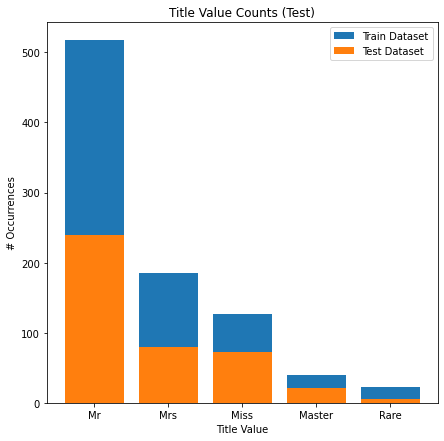

In [13]:
fig, ax = plt.subplots(figsize =(7, 7))
ax.bar(datasets[0]['Title'].unique(),datasets[0]['Title'].value_counts(), label='Train Dataset')
plt.title('Title Value Counts (Training)')
plt.ylabel('# Occurrences')
plt.xlabel('Title Value')
ax.bar(datasets[1]['Title'].unique(),datasets[1]['Title'].value_counts(), label='Test Dataset')
plt.title('Title Value Counts (Test)')
plt.ylabel('# Occurrences')
plt.xlabel('Title Value')
plt.legend()
plt.show()

In [14]:
# Begin discretization and categorical encoding
label = preprocessing.LabelBinarizer()
oe = preprocessing.OrdinalEncoder()

for dataset in datasets:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Title_Code'] = oe.fit_transform(dataset['Title'].array.reshape(-1, 1))

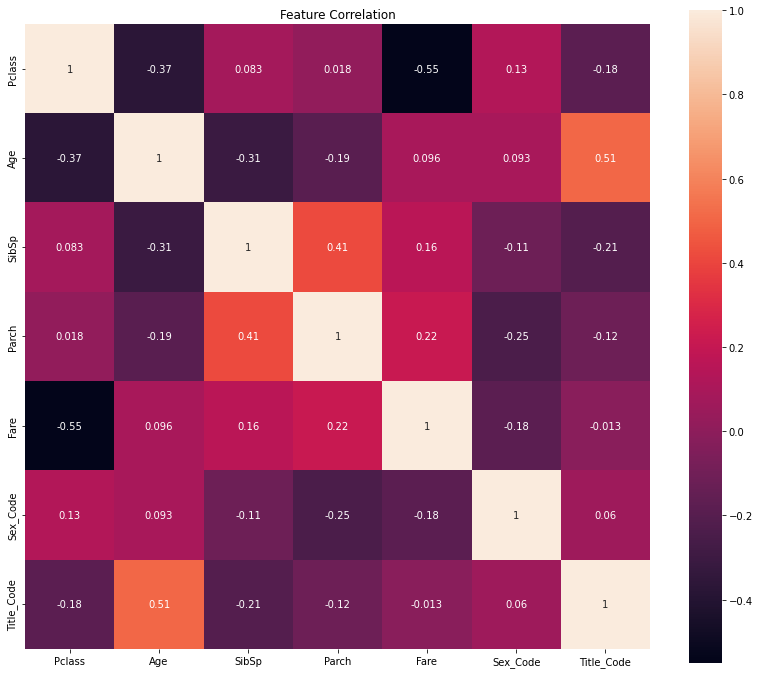

In [15]:
# Before completing Age and Fare, we must find the features with the highest correlation scores
correlation_heatmap(trainCopy.drop(['PassengerId', 'Survived'], axis=1))

In [16]:
# For Age, the feature with the highest Pearson correlation score is Title_Code (0.51)
# We use the median age for each Title_Code to fill missing age values.
# We do the same with Fare and Pclass.
# We complete the categorical Embarked feature by filling missing values with the mode of the entire dataset
for dataset in datasets:
    dataset['Age'] = dataset.groupby('Title', as_index = True)['Age'].apply(lambda age: age.fillna(age.median()))
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'] = dataset.groupby('Pclass', as_index = True)['Fare'].apply(lambda fare: fare.fillna(fare.median()))
    
    # We also take this opportunity to engineer the FamilySize and AgeClassInteraction features
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['AgeClassInteraction'] = dataset['Age'] * dataset['Pclass']

In [17]:
# Since both Fare and Age are now complete, we finish with discretization and categorical encoding

fare_bins = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
age_bins = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
age_class_bins = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

for dataset in datasets:
    dataset['FareBin_Code'] = fare_bins.fit_transform(dataset['Fare'].array.reshape(-1, 1))
    dataset['AgeBin_Code'] = age_bins.fit_transform(dataset['Age'].array.reshape(-1, 1))
    dataset['AgeClassBin_Code'] = age_class_bins.fit_transform(dataset['AgeClassInteraction'].array.reshape(-1, 1))
    dataset['Embarked_Code'] = oe.fit_transform(dataset['Embarked'].array.reshape(-1, 1))

In [18]:
# Determine Columns to Use in Preprocessing
    # List of columns to use in creating the model and the data type
    #   'C' - Categorical
    #   'N' - Numeric
    #   'O' - Ordinal
colList = [('Pclass', 'C'), ('Sex', 'C'), ('Age', 'N'), ('SibSp', 'N'), ('Parch', 'N'), ('Fare', 'N'),
           ('Embarked', 'C'), ('Title', 'C'), ('FamilySize', 'N'), ('AgeClassInteraction', 'N')]

In [19]:
# Preprocess Data
preprocessedDatasets = [preprocessData(datasets[0], datasets[1], colList), 
                        preprocessData(datasets[1], datasets[0], colList)]

In [20]:
# Create Model(s) #########################################
    # Inspiration for Classifier Models was taken from the following page
    # https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
classifiers = [
    ("10 Nearest Neighbors (Brute)", KNeighborsClassifier(n_neighbors=10, algorithm='brute')),
    ("Default Nearest Neighbors", KNeighborsClassifier()),
    ("SVM", SVC()),
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Neural Net", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("Custom Ensemble", EnsembleEstimator()),
]
classifiers.append(('VotingClassifier', VotingClassifier(estimators=classifiers[:-1])))

models = []
for i in range(len(classifiers)):
    models.append((classifiers[i][0], classifiers[i][1].fit(preprocessedDatasets[0], datasets[0]['Survived'])))

In [21]:
# Get Predictions
summaryDF = testData[['PassengerId']].copy(deep=True)
resultDFs = [] # List of tuples of Model name, [0], and resulting dataframe (columns PassengerId and Survived), [1]

for model in models:
    resultDFs.append((model[0], getPredictions(model[1], testData['PassengerId'], preprocessedDatasets[1])))
    summaryDF[model[0]] = resultDFs[-1][1]['Survived']

In [23]:
print('Scoring Models:')
scoresDict = {}
results = []
for classifier in classifiers:
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
    cv_results = model_selection.cross_validate(classifier[1], preprocessedDatasets[0], trainCopy['Survived'],
                    cv  = cv_split, scoring = 'accuracy')
    score = cv_results['test_score'].max()
    scoresDict[classifier[0]] = score
    print('    ' + classifier[0] + ': ' + str(score) + ', Mean: ' + str(cv_results['test_score'].mean()) + ', Min: ' + str(cv_results['test_score'].min()))
    #print(cv_results)
    results.append((classifier[0], cv_results))
    #print('\n\n')


Scoring Models:
    10 Nearest Neighbors (Brute): 0.7350746268656716, Mean: 0.6940298507462687, Min: 0.6529850746268657
    Default Nearest Neighbors: 0.75, Mean: 0.6985074626865672, Min: 0.667910447761194
    SVM: 0.753731343283582, Mean: 0.7022388059701491, Min: 0.6455223880597015
    Gaussian Process: 0.75, Mean: 0.7119402985074627, Min: 0.664179104477612
    Decision Tree: 0.8097014925373134, Mean: 0.7768656716417911, Min: 0.7388059701492538
    Random Forest: 0.8544776119402985, Mean: 0.8164179104477614, Min: 0.7947761194029851
    Neural Net: 0.8582089552238806, Mean: 0.8220149253731343, Min: 0.8022388059701493
    AdaBoost: 0.8470149253731343, Mean: 0.8126865671641792, Min: 0.7873134328358209
    Naive Bayes: 0.8470149253731343, Mean: 0.8007462686567164, Min: 0.753731343283582
    QDA: 0.7089552238805971, Mean: 0.6104477611940299, Min: 0.4141791044776119
    Custom Ensemble: 0.8694029850746269, Mean: 0.819776119402985, Min: 0.7686567164179104
    VotingClassifier: 0.854477611940

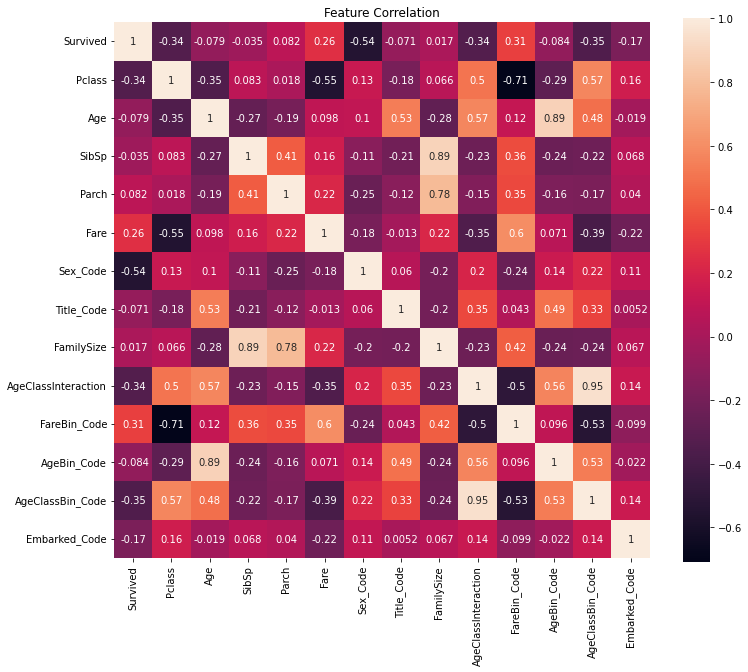

In [42]:
# Heatmap with full list of features available
correlation_heatmap(trainCopy.drop(['PassengerId'], axis=1))

In [95]:
######## Hypertuned Decision Tree  #########

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)

# list of discretized and encoded features
columns = [
    'Sex_Code',
    'Pclass', 
    'Embarked_Code', 
    'Title_Code', 
    'FamilySize', 
    'AgeBin_Code', 
    'FareBin_Code'
]

target = 'Survived'

# DTC with default params
default_tree = DecisionTreeClassifier(random_state = 0)

default_cv = model_selection.cross_validate(default_tree, trainCopy[columns], trainCopy[target],
                                                 cv  = cv_split, return_train_score=True)

default_tree.fit(trainCopy[columns], trainCopy[target])
print('Mean TEST score for default tree: ', default_cv['test_score'].mean())


# Parameter grid to be used in GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,4,6,8,10,None],
    'min_samples_split': [2,5,10,.03,.05],
    'min_samples_leaf': [1,5,10,.03,.05],
    'max_features': [None, 'auto', 'all'],
    'random_state': [0]
}

# Using recursive feature elimination (RFE) with cross-validation to refine & tune tree
# (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)

# feature selection cross validation to construct new tree
rfe_tree = feature_selection.RFECV(default_tree, step = 1, cv = cv_split, scoring = 'accuracy')
rfe_tree.fit(trainCopy[columns], trainCopy[target])

# Get new features list with recursive features removed
columns_rfe = trainCopy[columns].columns.values[rfe_tree.get_support()]

rfe_results = model_selection.cross_validate(default_tree, trainCopy[columns_rfe], trainCopy[target], cv  = cv_split, return_train_score=True)

# Tune rfe_tree
rfe_tuned = model_selection.GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv = cv_split, return_train_score=True)
rfe_tuned.fit(trainCopy[columns_rfe], trainCopy[target])

print('\nbest params for tuned rfe_tree:\n' + 25*'-')
for key, value in rfe_tuned.best_params_.items():
    print(key + ': ' + str(value))
print(25*'-' + '\n')

print('columns: ', columns_rfe)
print('\n\tfeature(s) eliminated:')
flag = False
for i in trainCopy[columns]:
    if (columns_rfe.tolist().count(i) == 0):
        flag=True
        print('\t\t', i)
if flag == False:
    print('\t\tNone')

print('\nHypertuned Decision Tree Mean Test Score: ' + str(rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_]))


Mean TEST score for default tree:  0.7981343283582089

best params for tuned rfe_tree:
-------------------------
criterion: gini
max_depth: 4
max_features: None
min_samples_leaf: 1
min_samples_split: 10
random_state: 0
splitter: best
-------------------------

columns:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']

	feature(s) eliminated:
		None

Hypertuned Decision Tree Mean Test Score: 0.8770215661024281


In [84]:
preds = rfe_tuned.best_estimator_.fit(trainCopy[columns_rfe], trainCopy[target]).predict(testCopy[columns_rfe])
submission = pd.concat([testCopy['PassengerId'], pd.DataFrame({'Survived' : preds})], axis=1)
submission.to_csv(path_or_buf='modelSummary ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

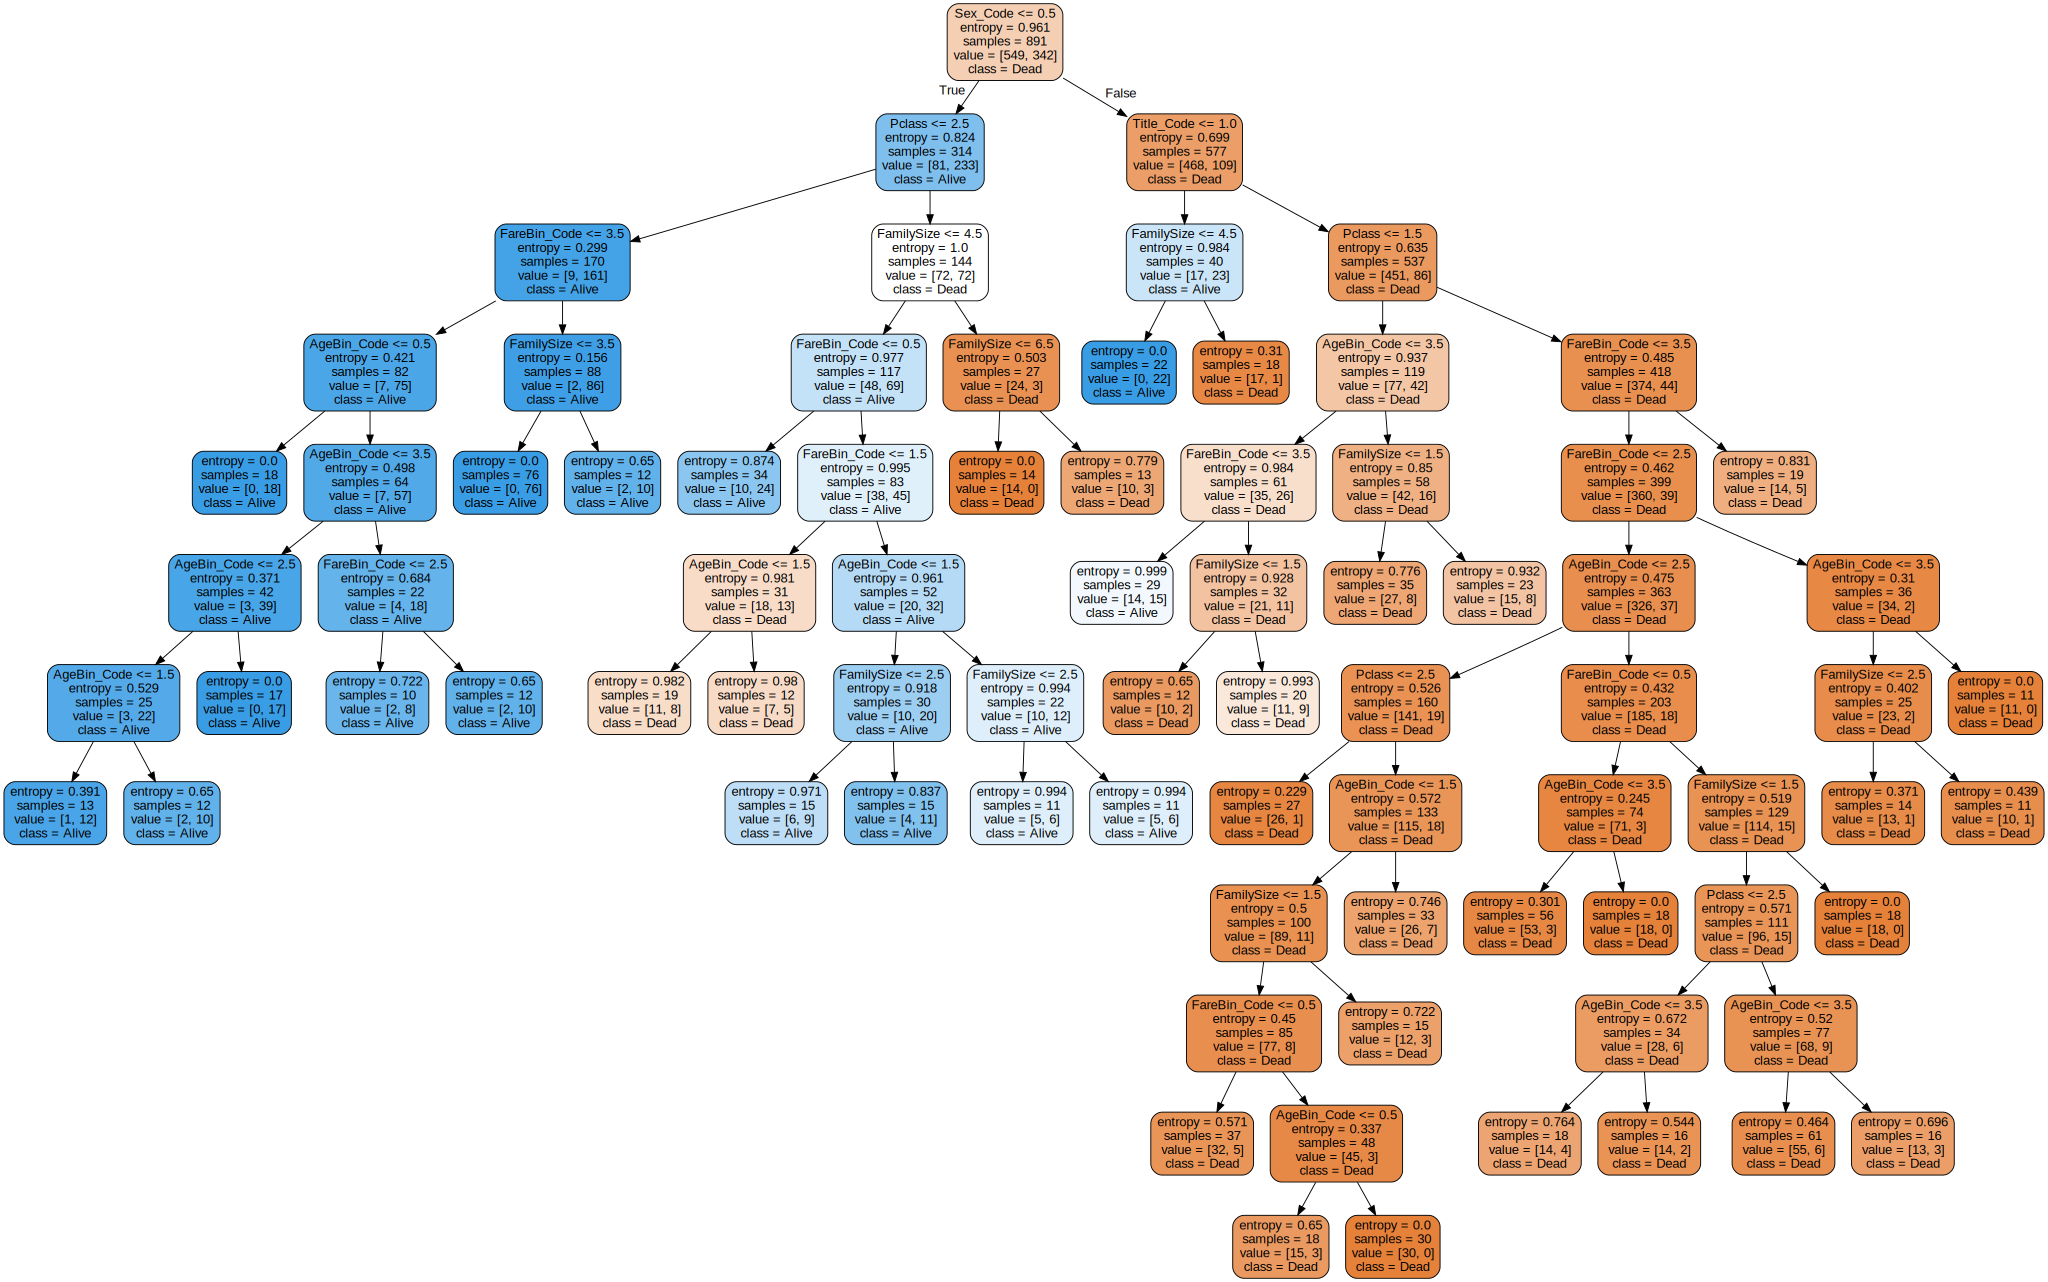

In [94]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(rfe_tuned.best_estimator_, out_file=None, 
                                feature_names = columns_rfe, class_names = ['Dead', 'Alive'],
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

In [25]:
plotInfo = {'classifierNum' : [], 'fitTimeMax' : [], 'scoreTimeMax' : [], 'testScoreMax' : [],
            'fitTimeMean' : [], 'scoreTimeMean' : [], 'testScoreMean' : [], 'labels' : []}
for index, result in enumerate(results):
    plotInfo['classifierNum'].append(index)
    plotInfo['fitTimeMax'].append(result[1]['fit_time'].max())
    plotInfo['fitTimeMean'].append(result[1]['fit_time'].mean())
    plotInfo['scoreTimeMax'].append(result[1]['score_time'].max())
    plotInfo['scoreTimeMean'].append(result[1]['score_time'].mean())
    plotInfo['testScoreMax'].append(result[1]['test_score'].max())
    plotInfo['testScoreMean'].append(result[1]['test_score'].mean())
    plotInfo['labels'].append(result[0])
    
# Add Hypertuned Tree to plotInfo
plotInfo['classifierNum'].append(index)
plotInfo['fitTimeMax'].append(rfe_tuned.cv_results_['mean_fit_time'][rfe_tuned.best_index_])
plotInfo['fitTimeMean'].append(rfe_tuned.cv_results_['mean_fit_time'][rfe_tuned.best_index_])
plotInfo['scoreTimeMax'].append(rfe_tuned.cv_results_['mean_score_time'][rfe_tuned.best_index_])
plotInfo['scoreTimeMean'].append(rfe_tuned.cv_results_['mean_score_time'][rfe_tuned.best_index_])
plotInfo['testScoreMax'].append(rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_])
plotInfo['testScoreMean'].append(rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_])
plotInfo['labels'].append('Hypertuned Decision Tree')

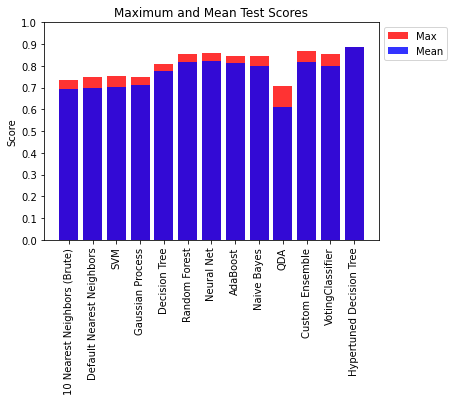

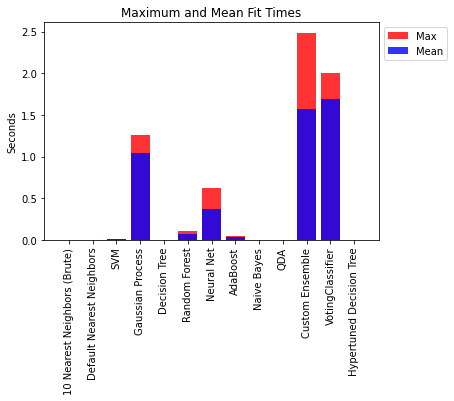

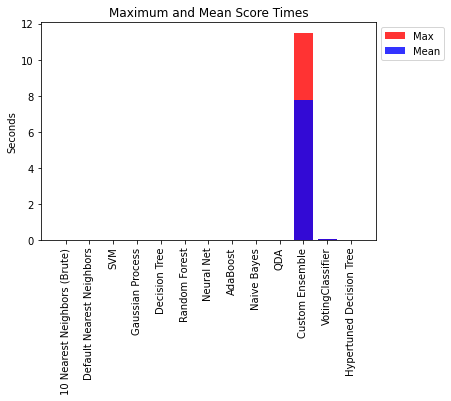

In [26]:
# Plot Test Scores
plt.bar(plotInfo['labels'], plotInfo['testScoreMax'], color='r', alpha=0.8, label='Max')
plt.bar(plotInfo['labels'], plotInfo['testScoreMean'], color='b', alpha=0.8, label='Mean')
plt.title('Maximum and Mean Test Scores')
plt.ylabel('Score')
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

# Plot Fit Times
plt.bar(plotInfo['labels'], plotInfo['fitTimeMax'], color='r', alpha=0.8, label='Max')
plt.bar(plotInfo['labels'], plotInfo['fitTimeMean'], color='b', alpha=0.8, label='Mean')
plt.title('Maximum and Mean Fit Times')
plt.ylabel('Seconds')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

# Plot Score Times
plt.bar(plotInfo['labels'], plotInfo['scoreTimeMax'], color='r', alpha=0.8, label='Max')
plt.bar(plotInfo['labels'], plotInfo['scoreTimeMean'], color='b', alpha=0.8, label='Mean')
plt.title('Maximum and Mean Score Times')
plt.ylabel('Seconds')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

In [27]:
# #Plot Accuracy Summary
# #Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# import itertools
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Greens):
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = metrics.confusion_matrix(trainCopy['Survived'], ada_boost_predictions)
# np.set_printoptions(precision=2)

# class_names = ['Dead', 'Survived']
# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
#                       title='Normalized confusion matrix')

In [28]:
# Uncomment to save .csv of all results
#finalDF.to_csv(path_or_buf='modelSummary ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

In [29]:
# Result DataFrame to .csv for Kaggle Submission
# Uncomment and specify classifier number to use to save to .csv
#resultDFs[10][1].to_csv(path_or_buf='kaggle_submission ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')
#print(resultDFs[10][0])

In [30]:
# plt.figure(figsize=[16,12])

# plt.subplot(234)
# plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Pclass'], trainCopy[trainCopy['Survived']==0]['Pclass']], 
#          stacked=True, color = ['g','r'],label = ['Survived','Dead'])
# plt.title('Survival by Passenger Class')
# plt.xlabel('Pclass')
# plt.ylabel('# of Passengers')
# plt.legend()

# plt.subplot(235)
# plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Age'], trainCopy[trainCopy['Survived']==0]['Age']], 
#          stacked=True, color = ['g','r'],label = ['Survived','Dead'])
# plt.title('Survival by Age')
# plt.xlabel('Age (Years)')
# plt.ylabel('# of Passengers')
# plt.legend()

# plt.subplot(236)
# plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Sex'], trainCopy[trainCopy['Survived']==0]['Sex']], 
#          stacked=True, color = ['g','r'],label = ['Survived','Dead'])
# plt.title('Sex Survival')
# plt.xlabel('Sex (Male or Female)')
# plt.ylabel('# of Passengers')
# plt.legend()